Open-source software deveopment is characterized by a collaborative approach to software creation, where developers from around the world can contribute to projects. We want to understand how this collaboration works in terms of configuration responsibility. In this context, configuration responsibility refers to the ability of developers to make changes to the software's configuration files, which can include settings, dependencies, and other important parameters that affect the software's behavior. We are interested in how this responsibility is distributed among developers, and how it affects the overall development process. Are there specific roles or permissions that dictate who can make changes to configuration files? Are there any knowledge islands, allowing only a few contributors to change configuration? Or are the configuration responsibilities shared among all contributors? Understanding these dynamics can provide insights into the collaborative nature of open-source software development and help identify best practices for managing configuration responsibilities in such projects.

In [ ]:
import json
import pandas as pd
from typing import Dict
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [34]:
def get_contributors_and_files(data: Dict) -> pd.DataFrame:
    # Extract relevant commit data
    commit_data = data.get("commit_data", [])

    # Dictionary to store contributor stats
    contributors_stats = defaultdict(lambda: {
        "config_commits": 0,
        "non_config_commits": 0,
        "files_changed": defaultdict(int)
    })

    # Process each commit
    for commit in commit_data:
        author = commit["author"].lower()
        is_config_related = commit["is_config_related"]
        changed_files = commit["network_data"].get("config_file_data", []) if commit["network_data"] else []

        # Count config and non-config commits
        if is_config_related:
            contributors_stats[author]["config_commits"] += 1
        else:
            contributors_stats[author]["non_config_commits"] += 1

        # Count files changed per contributor
        for file in changed_files:
            if file["is_modified"]:
                contributors_stats[author]["files_changed"][file["file_path"]] += 1

    # Create two separate DataFrames: one for commit statistics and one for changed files
    commit_stats_rows = []
    changed_files_rows = []

    for contributor, stats in contributors_stats.items():
        commit_stats_rows.append({
            "Contributor": contributor,
            "Config Commits": stats["config_commits"],
            "Non-Config Commits": stats["non_config_commits"]
        })
        
        for file, count in stats["files_changed"].items():
            changed_files_rows.append({
                "Contributor": contributor,
                "Changed File": file,
                "File Change Count": count
            })

    # Convert to DataFrames
    commit_stats_df = pd.DataFrame(commit_stats_rows)
    changed_files_df = pd.DataFrame(changed_files_rows)
    commit_stats_df = commit_stats_df.sort_values(by="Config Commits", ascending=False)

    return commit_stats_df, changed_files_df


data_file = "../data/test_projects/piggymetrics.json"
with open(data_file, "r") as file:
    data = json.load(file)

commit_stats_df, changed_files_df = get_contributors_and_files(data)
commit_stats_df

,Contributor,Config Commits,Non-Config Commits
1,sqshq <sqshq@sqshq.com>,81,58
13,chi dov <d.chiproeng@gmail.com>,21,18
4,alexander lukyanchikov <sqshq@sqshq.com>,18,61
2,alukyanchikov <alukyanchikov@at-consulting.ru>,3,0
5,steve peak <steve@codecov.io>,2,0
7,patrick cornelißen <pcornelissen@orchit.de>,2,0
0,александр лукьянчиков <sqshq@macbook.local>,1,0
15,thanus <tthanusijan@gmail.com>,1,0
20,siarhei piashko <siarhei.piashko@seavus.com>,1,2
19,elkolotfi <elkolotfi@gmail.com>,1,1


*Who drives configuration changes?*

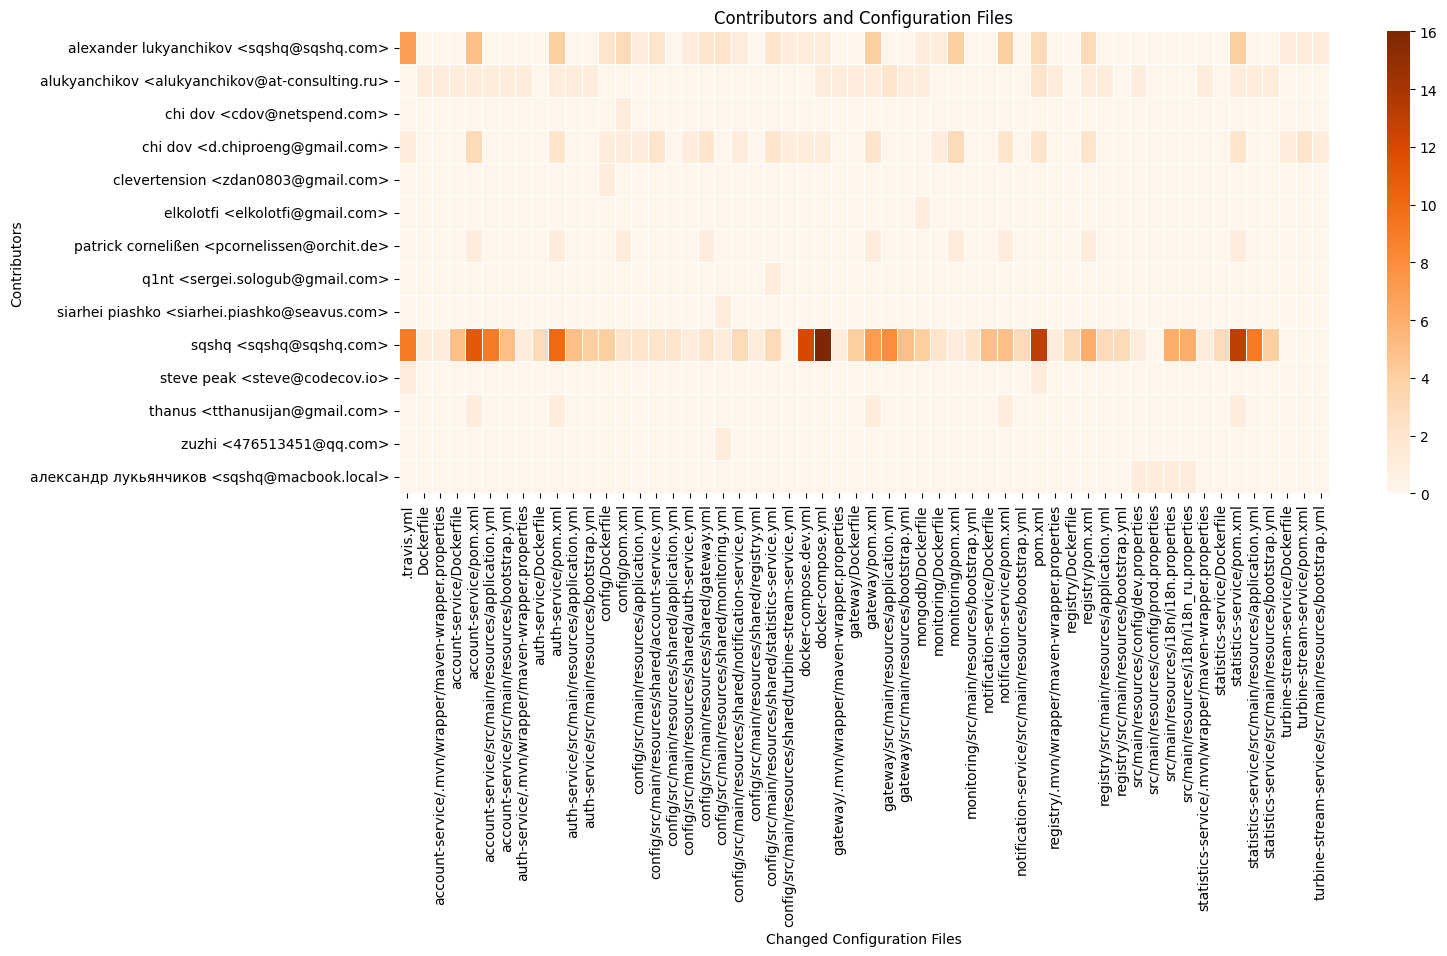

In [35]:
def plot_contributors_and_files(df_files: pd.DataFrame):
    # Create a pivot table for heatmap with all contributors
    pivot_df = df_files.pivot(index="Contributor", columns="Changed File", values="File Change Count").fillna(0)

    # Plot heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(pivot_df, cmap="Oranges", linewidths=0.5, annot=False)
    plt.xlabel("Changed Configuration Files")
    plt.ylabel("Contributors")
    plt.title("Contributors and Configuration Files")
    plt.show()


plot_contributors_and_files(df_files=changed_files_df)

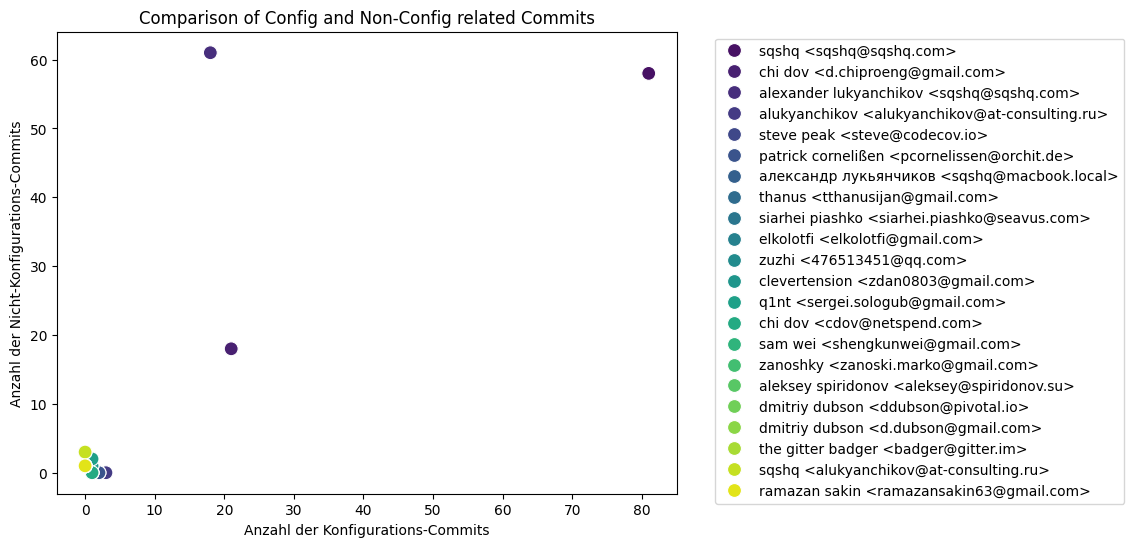

In [36]:
def plot_commit_comparison(df_commits: pd.DataFrame):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=commit_stats_df, x="Config Commits", y="Non-Config Commits", hue="Contributor", palette="viridis", s=100)
    plt.title("Comparison of Config and Non-Config related Commits")
    plt.xlabel("Anzahl der Konfigurations-Commits")
    plt.ylabel("Anzahl der Nicht-Konfigurations-Commits")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

plot_commit_comparison(df_commits=commit_stats_df)

*Which contributors require configuration coordination?*

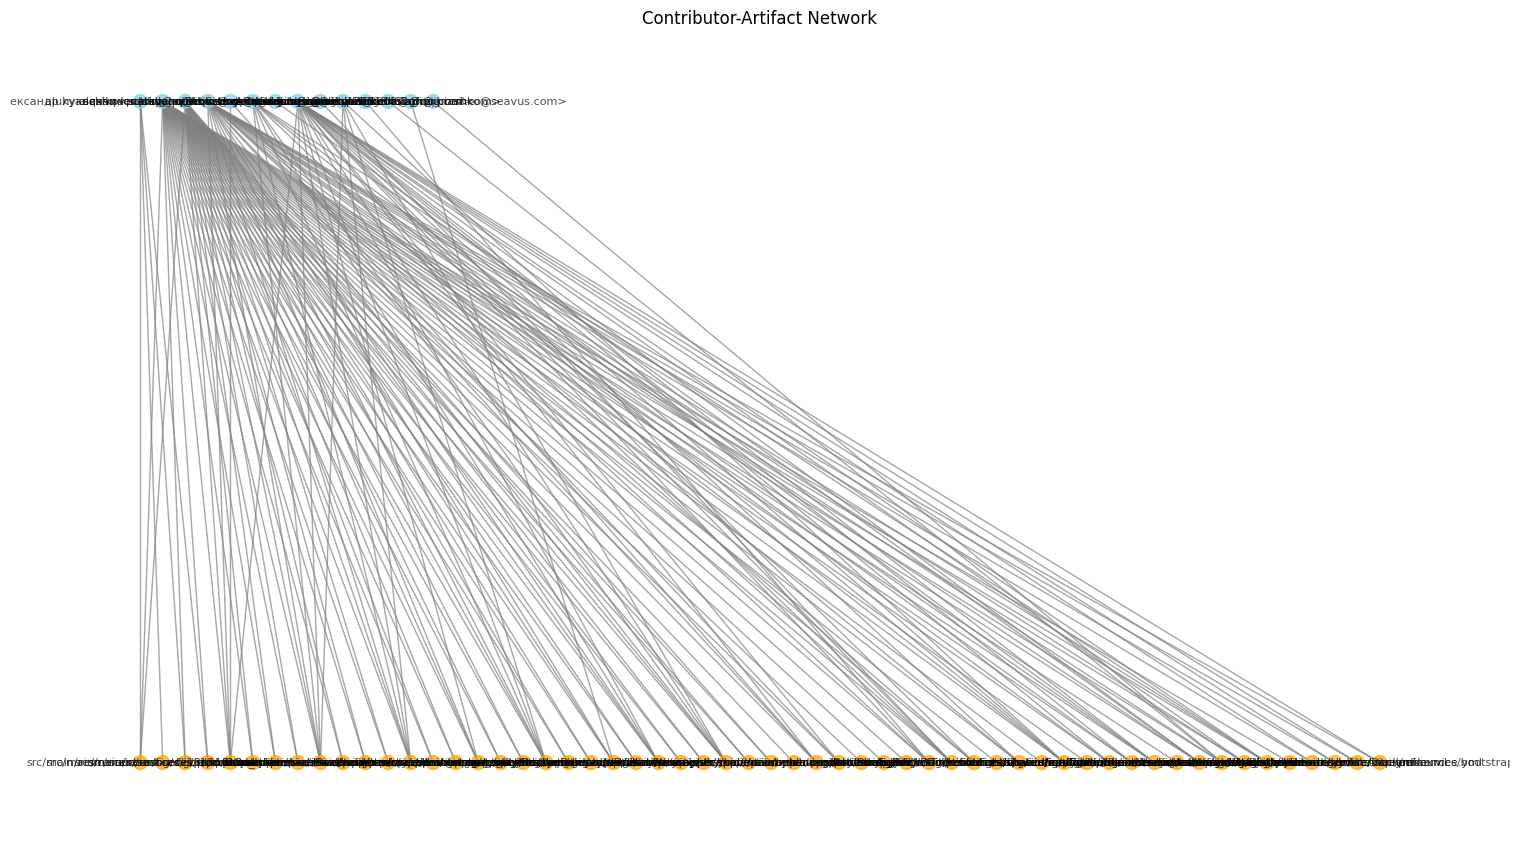

In [54]:
def plot_contributor_artifact_network(df_files: pd.DataFrame, top_n: int = 5):
    # Erstellen eines bipartiten Graphen
    B = nx.Graph()

    # Hinzufügen von Contributor-Knoten und Config-File-Knoten
    contributors = changed_files_df["Contributor"].unique()
    config_files = changed_files_df["Changed File"].unique()

    B.add_nodes_from(contributors, bipartite=0)  # Contributor-Knoten
    B.add_nodes_from(config_files, bipartite=1)  # Config-File-Knoten

    # Hinzufügen von Kanten basierend auf Änderungen
    for _, row in changed_files_df.iterrows():
        contributor = row["Contributor"]
        config_file = row["Changed File"]
        B.add_edge(contributor, config_file, weight=row["File Change Count"])

    # Benutzerdefiniertes Layout für die Ebenen
    pos = {}
    x_spacing = 3  # Abstand zwischen den Knoten in einer Ebene
    y_spacing = 5  # Abstand zwischen den Ebenen

    # Position der Contributor-Knoten (Ebene 1)
    for i, contributor in enumerate(contributors):
        pos[contributor] = (i * x_spacing, 0)

    # Position der Config-File-Knoten (Ebene 2)
    for i, config_file in enumerate(config_files):
        pos[config_file] = (i * x_spacing, -y_spacing)

    # Visualisierung des Netzwerks
    plt.figure(figsize=(15, 8))
    nx.draw(B, pos, with_labels=True, node_size=100, node_color=["skyblue" if n in contributors else "orange" for n in B.nodes()],
            font_size=8, edge_color="gray", alpha=0.7)
    plt.title("Contributor-Artifact Network")
    plt.show()

plot_contributor_artifact_network(df_files=changed_files_df)

/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_48012/703000013.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_files.values, y=top_files.index, palette="Reds_d")


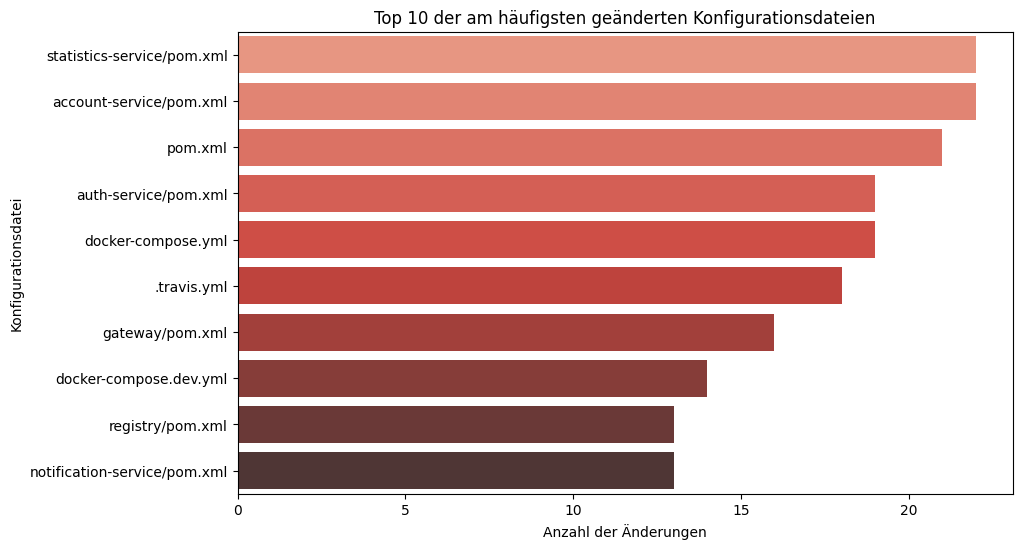

In [39]:
def plot_most_changed_files(df_files: pd.DataFrame):
    top_files = changed_files_df.groupby("Changed File")["File Change Count"].sum().sort_values(ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_files.values, y=top_files.index, palette="Reds_d")
    plt.title("Top 10 der am häufigsten geänderten Konfigurationsdateien")
    plt.xlabel("Anzahl der Änderungen")
    plt.ylabel("Konfigurationsdatei")
    plt.show()

plot_most_changed_files(df_files=changed_files_df)